In [117]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [10]:
data = pd.read_sql("SELECT * FROM measurement", conn)
data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [14]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [15]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [94]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [63]:
# Find the most recent date in the data set.
date_list = []
for row in session.query(measurement.date).all():
    date_value = row[0]
    date_list.append(date_value)

most_recent_date = max(date_list, key=lambda x: x)
most_recent_date

'2017-08-23'

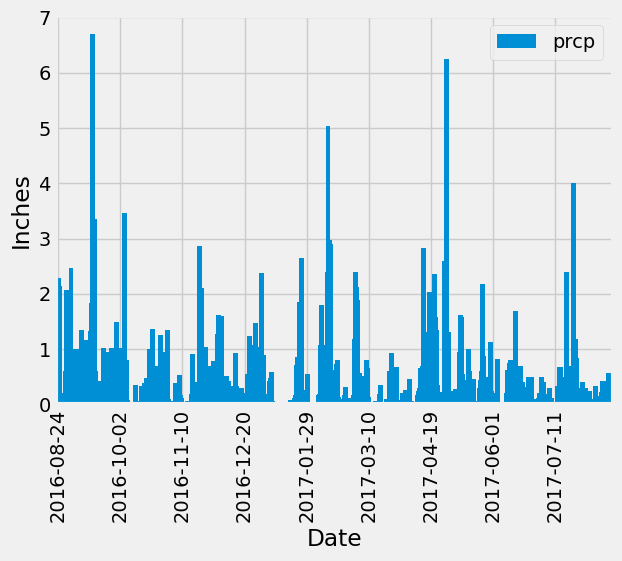

In [141]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date_format = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_from_last_date = most_recent_date_format + timedelta(days=-365)
result = one_year_from_last_date.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores

precipitation_scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > result).\
    order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(precipitation_scores, columns=['date', 'prcp'])

# Sort the dataframe by date
sorted_df = df.sort_values('date', ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
y='prcp'
x='date'
df.plot(x='date',y='prcp', kind='bar',width=20)
num_xticks = 10
locator = ticker.MaxNLocator(num_xticks)
plt.gca().xaxis.set_major_locator(locator)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()


In [109]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date_format = datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_from_last_date = most_recent_date_format + timedelta(days=-365)
result = one_year_from_last_date.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, 
       func.avg(measurement.prcp)]
precipitation_scores = session.query(*sel).\
    filter(measurement.date > result).\
    group_by(measurement.date).\
    order_by(measurement.date).all()
df = pd.DataFrame(precipitation_scores, columns=['Date', 'Value'])

df

,Date,Value
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667
...,...,...
360,2017-08-19,0.030000
361,2017-08-20,0.005000
362,2017-08-21,0.193333
363,2017-08-22,0.166667


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

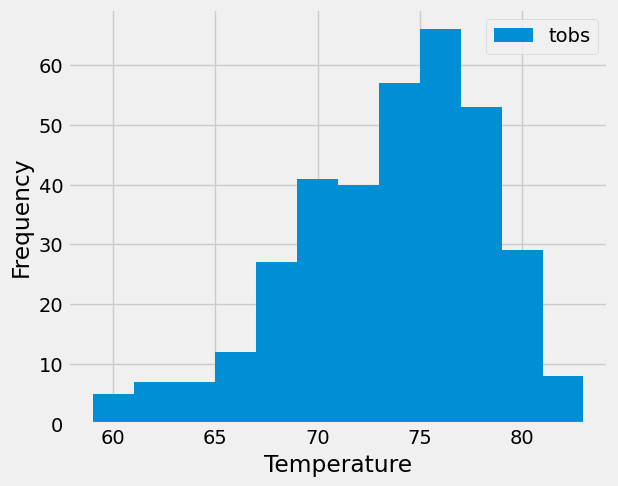

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()